<a href="https://colab.research.google.com/github/Sahasra337/Detection-Of-ACL-Tear-using-CNN/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorboardX


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm # Make sure tqdm is imported
from tqdm.notebook import tqdm as tqdm_notebook
import os
import torch
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F


from sklearn import metrics

In [ ]:
!pip install scikit-learn matplotlib


In [ ]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm # Make sure tqdm is imported
from tqdm.notebook import tqdm as tqdm_notebook
import os
import torch
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F


from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay

In [ ]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.utils.data as data
from torchvision import transforms


class MRDataset(data.Dataset):
    def __init__(self, root_dir, task, plane, train=True, transform=None, weights=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = torch.FloatTensor([1, neg / pos])
        else:
            self.weights = torch.FloatTensor(weights)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index])
        label = self.labels[index]
        if label == 1:
            label = torch.FloatTensor([[0, 1]])
        elif label == 0:
            label = torch.FloatTensor([[1, 0]])

        if self.transform:
            array = self.transform(array)
        else:
            array = np.stack((array,)*3, axis=1)
            array = torch.FloatTensor(array)

        # if label.item() == 1:
        #     weight = np.array([self.weights[1]])
        #     weight = torch.FloatTensor(weight)
        # else:
        #     weight = np.array([self.weights[0]])
        #     weight = torch.FloatTensor(weight)

        return array, label, self.weights


In [ ]:
import torch
import torch.nn as nn
from torchvision import models


class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model = models.alexnet(pretrained=True)
        self.pooling_layer = nn.AdaptiveAvgPool2d(1)
        self.classifer = nn.Linear(256, 2)

    def forward(self, x):
        x = torch.squeeze(x, dim=0)
        features = self.pretrained_model.features(x)
        pooled_features = self.pooling_layer(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        flattened_features = torch.max(pooled_features, 0, keepdim=True)[0]
        output = self.classifer(flattened_features)
        return output

In [ ]:
import shutil
import os
import time
from datetime import datetime
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter

from sklearn import metrics


def train_model(model, train_loader, epoch, num_epochs, optimizer, writer, current_lr, log_every=100):
    _ = model.train()

    if torch.cuda.is_available():
        model.cuda()

    y_preds = []
    y_trues = []
    losses = []

    for i, (image, label, weight) in enumerate(train_loader):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        label = label[0]
        weight = weight[0]

        prediction = model.forward(image.float())

        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0][1]))
        y_preds.append(probas[0][1].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        writer.add_scalar('Train/Loss', loss_value,
                          epoch * len(train_loader) + i)
        writer.add_scalar('Train/AUC', auc, epoch * len(train_loader) + i)

        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Single batch number : {2} / {3} ]| avg train loss {4} | train auc : {5} | lr : {6}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(train_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      current_lr
                  )
                  )

    writer.add_scalar('Train/AUC_epoch', auc, epoch + i)

    train_loss_epoch = np.round(np.mean(losses), 4)
    train_auc_epoch = np.round(auc, 4)
    return train_loss_epoch, train_auc_epoch


def evaluate_model(model, val_loader, epoch, num_epochs, writer, current_lr, log_every=20):
    _ = model.eval()

    if torch.cuda.is_available():
        model.cuda()

    y_trues = []
    y_preds = []
    losses = []

    for i, (image, label, weight) in enumerate(val_loader):

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        label = label[0]
        weight = weight[0]

        prediction = model.forward(image.float())

        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)

        loss_value = loss.item()
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0][1]))
        y_preds.append(probas[0][1].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        writer.add_scalar('Val/Loss', loss_value, epoch * len(val_loader) + i)
        writer.add_scalar('Val/AUC', auc, epoch * len(val_loader) + i)

        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Single batch number : {2} / {3} ] | avg val loss {4} | val auc : {5} | lr : {6}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(val_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      current_lr
                  )
                  )

    writer.add_scalar('Val/AUC_epoch', auc, epoch + i)

    val_loss_epoch = np.round(np.mean(losses), 4)
    val_auc_epoch = np.round(auc, 4)
    return val_loss_epoch, val_auc_epoch

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def run(args):
    log_root_folder = "./logs/{0}/{1}/".format(args.task, args.plane)
    if args.flush_history == 1:
        objects = os.listdir(log_root_folder)
        for f in objects:
            if os.path.isdir(log_root_folder + f):
                shutil.rmtree(log_root_folder + f)

    now = datetime.now()
    logdir = log_root_folder + now.strftime("%Y%m%d-%H%M%S") + "/"
    os.makedirs(logdir)

    writer = SummaryWriter(logdir)


    train_dataset = MRDataset('/content/drive/MyDrive/ACL DATASET/', args.task,
                              args.plane, train=True)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=11, drop_last=False)

    validation_dataset = MRDataset(
        '/content/drive/MyDrive/ACL DATASET/', args.task, args.plane, train=False)
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=1, shuffle=-True, num_workers=11, drop_last=False)

    mrnet = MRNet()

    if torch.cuda.is_available():
        mrnet = mrnet.cuda()

    optimizer = optim.Adam(mrnet.parameters(), lr=args.lr, weight_decay=0.1)

    if args.lr_scheduler == "plateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=3, factor=.3, threshold=1e-4, verbose=True)
    elif args.lr_scheduler == "step":
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=3, gamma=args.gamma)

    best_val_loss = float('inf')
    best_val_auc = float(0)

    num_epochs = args.epochs
    iteration_change_loss = 0
    patience = args.patience
    log_every = args.log_every

    t_start_training = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(optimizer)

        t_start = time.time()

        train_loss, train_auc = train_model(
            mrnet, train_loader, epoch, num_epochs, optimizer, writer, current_lr, log_every)
        val_loss, val_auc = evaluate_model(
            mrnet, validation_loader, epoch, num_epochs, writer, current_lr)

        if args.lr_scheduler == 'plateau':
            scheduler.step(val_loss)
        elif args.lr_scheduler == 'step':
            scheduler.step()

        t_end = time.time()
        delta = t_end - t_start

        print("train loss : {0} | train auc {1} | val loss {2} | val auc {3} | elapsed time {4} s".format(
            train_loss, train_auc, val_loss, val_auc, delta))

        iteration_change_loss += 1
        print('-' * 30)

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            if bool(args.save_model):
                file_name = f'model_{args.prefix_name}_{args.task}_{args.plane}_val_auc_{val_auc:0.4f}_train_auc_{train_auc:0.4f}_epoch_{epoch+1}.pth'
                model_path = f'/content/drive/MyDrive/Minor Project files/{file_name}'
                for f in os.listdir('/content/drive/MyDrive/Minor Project files/'):
                    if (args.task in f) and (args.plane in f) and (args.prefix_name in f):
                        os.remove(f'/content/drive/MyDrive/Minor Project files/{f}')
                torch.save(mrnet, model_path)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            iteration_change_loss = 0

        if iteration_change_loss == patience:
            print('Early stopping after {0} iterations without the decrease of the val loss'.
                  format(iteration_change_loss))
            break

    t_end_training = time.time()
    print(f'training took {t_end_training - t_start_training} s')


def parse_arguments():
    class Args:
        def __init__(self):
            self.task = 'acl'  # Set your task
            self.plane = 'axial'  # Set your plane
            self.prefix_name = 'model'
            self.augment = 1
            self.lr_scheduler = 'plateau'
            self.gamma = 0.5
            self.epochs = 2
            self.lr = 1e-5
            self.flush_history = 0
            self.save_model = 1
            self.patience = 5
            self.log_every = 100

    return Args()


if __name__ == "__main__":
    args = parse_arguments()
    run(args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvis

[Epoch: 1 / 2 |Single batch number : 100 / 1130 ]| avg train loss 5.1578 | train auc : 0.5609 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 200 / 1130 ]| avg train loss 4.224 | train auc : 0.5244 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 300 / 1130 ]| avg train loss 3.4606 | train auc : 0.5781 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 400 / 1130 ]| avg train loss 3.1945 | train auc : 0.5961 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 500 / 1130 ]| avg train loss 2.9998 | train auc : 0.5891 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 600 / 1130 ]| avg train loss 2.9065 | train auc : 0.5921 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 700 / 1130 ]| avg train loss 2.7841 | train auc : 0.593 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 800 / 1130 ]| avg train loss 2.6839 | train auc : 0.5943 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 900 / 1130 ]| avg train loss 2.617 | train auc : 0.6046 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 100

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch: 1 / 2 |Single batch number : 20 / 120 ] | avg val loss 1.4376 | val auc : 0.6837 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 40 / 120 ] | avg val loss 1.0665 | val auc : 0.7548 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 60 / 120 ] | avg val loss 1.0006 | val auc : 0.7791 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 80 / 120 ] | avg val loss 0.9719 | val auc : 0.7506 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 100 / 120 ] | avg val loss 0.9767 | val auc : 0.7571 | lr : 1e-05
train loss : 2.4192 | train auc 0.601 | val loss 1.0147 | val auc 0.7365 | elapsed time 178.71300983428955 s
------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch: 2 / 2 |Single batch number : 100 / 1130 ]| avg train loss 0.8 | train auc : 0.8645 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 200 / 1130 ]| avg train loss 1.0027 | train auc : 0.8367 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 300 / 1130 ]| avg train loss 1.0157 | train auc : 0.8171 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 400 / 1130 ]| avg train loss 1.1329 | train auc : 0.7843 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 500 / 1130 ]| avg train loss 1.1239 | train auc : 0.7798 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 600 / 1130 ]| avg train loss 1.1591 | train auc : 0.7655 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 700 / 1130 ]| avg train loss 1.1043 | train auc : 0.7781 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 800 / 1130 ]| avg train loss 1.1267 | train auc : 0.7726 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 900 / 1130 ]| avg train loss 1.1799 | train auc : 0.7652 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 100

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch: 2 / 2 |Single batch number : 20 / 120 ] | avg val loss 0.8138 | val auc : 0.8333 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 40 / 120 ] | avg val loss 0.8442 | val auc : 0.744 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 60 / 120 ] | avg val loss 0.921 | val auc : 0.7613 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 80 / 120 ] | avg val loss 0.8907 | val auc : 0.7636 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 100 / 120 ] | avg val loss 0.8556 | val auc : 0.7671 | lr : 1e-05
train loss : 1.2117 | train auc 0.7757 | val loss 0.8588 | val auc 0.7584 | elapsed time 106.6122817993164 s
------------------------------
training took 287.692444562912 s


In [ ]:
import shutil
import os
import time
from datetime import datetime
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter

from sklearn import metrics


def train_model(model, train_loader, epoch, num_epochs, optimizer, writer, current_lr, log_every=100):
    _ = model.train()

    if torch.cuda.is_available():
        model.cuda()

    y_preds = []
    y_trues = []
    losses = []

    for i, (image, label, weight) in enumerate(train_loader):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        label = label[0]
        weight = weight[0]

        prediction = model.forward(image.float())

        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0][1]))
        y_preds.append(probas[0][1].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        writer.add_scalar('Train/Loss', loss_value,
                          epoch * len(train_loader) + i)
        writer.add_scalar('Train/AUC', auc, epoch * len(train_loader) + i)

        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Single batch number : {2} / {3} ]| avg train loss {4} | train auc : {5} | lr : {6}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(train_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      current_lr
                  )
                  )

    writer.add_scalar('Train/AUC_epoch', auc, epoch + i)

    train_loss_epoch = np.round(np.mean(losses), 4)
    train_auc_epoch = np.round(auc, 4)
    return train_loss_epoch, train_auc_epoch


def evaluate_model(model, val_loader, epoch, num_epochs, writer, current_lr, log_every=20):
    _ = model.eval()

    if torch.cuda.is_available():
        model.cuda()

    y_trues = []
    y_preds = []
    losses = []

    for i, (image, label, weight) in enumerate(val_loader):

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        label = label[0]
        weight = weight[0]

        prediction = model.forward(image.float())

        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)

        loss_value = loss.item()
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0][1]))
        y_preds.append(probas[0][1].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        writer.add_scalar('Val/Loss', loss_value, epoch * len(val_loader) + i)
        writer.add_scalar('Val/AUC', auc, epoch * len(val_loader) + i)

        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Single batch number : {2} / {3} ] | avg val loss {4} | val auc : {5} | lr : {6}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(val_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      current_lr
                  )
                  )

    writer.add_scalar('Val/AUC_epoch', auc, epoch + i)

    val_loss_epoch = np.round(np.mean(losses), 4)
    val_auc_epoch = np.round(auc, 4)
    return val_loss_epoch, val_auc_epoch

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def run(args):
    log_root_folder = "./logs/{0}/{1}/".format(args.task, args.plane)
    if args.flush_history == 1:
        objects = os.listdir(log_root_folder)
        for f in objects:
            if os.path.isdir(log_root_folder + f):
                shutil.rmtree(log_root_folder + f)

    now = datetime.now()
    logdir = log_root_folder + now.strftime("%Y%m%d-%H%M%S") + "/"
    os.makedirs(logdir)

    writer = SummaryWriter(logdir)


    train_dataset = MRDataset('/content/drive/MyDrive/ACL DATASET/', args.task,
                              args.plane, train=True)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=11, drop_last=False)

    validation_dataset = MRDataset(
        '/content/drive/MyDrive/ACL DATASET/', args.task, args.plane, train=False)
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=1, shuffle=-True, num_workers=11, drop_last=False)

    mrnet = MRNet()

    if torch.cuda.is_available():
        mrnet = mrnet.cuda()

    optimizer = optim.Adam(mrnet.parameters(), lr=args.lr, weight_decay=0.1)

    if args.lr_scheduler == "plateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=3, factor=.3, threshold=1e-4, verbose=True)
    elif args.lr_scheduler == "step":
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=3, gamma=args.gamma)

    best_val_loss = float('inf')
    best_val_auc = float(0)

    num_epochs = args.epochs
    iteration_change_loss = 0
    patience = args.patience
    log_every = args.log_every

    t_start_training = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(optimizer)

        t_start = time.time()

        train_loss, train_auc = train_model(
            mrnet, train_loader, epoch, num_epochs, optimizer, writer, current_lr, log_every)
        val_loss, val_auc = evaluate_model(
            mrnet, validation_loader, epoch, num_epochs, writer, current_lr)

        if args.lr_scheduler == 'plateau':
            scheduler.step(val_loss)
        elif args.lr_scheduler == 'step':
            scheduler.step()

        t_end = time.time()
        delta = t_end - t_start

        print("train loss : {0} | train auc {1} | val loss {2} | val auc {3} | elapsed time {4} s".format(
            train_loss, train_auc, val_loss, val_auc, delta))

        iteration_change_loss += 1
        print('-' * 30)

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            if bool(args.save_model):
                file_name = f'model_{args.prefix_name}_{args.task}_{args.plane}_val_auc_{val_auc:0.4f}_train_auc_{train_auc:0.4f}_epoch_{epoch+1}.pth'
                model_path = f'/content/drive/MyDrive/Minor Project files/{file_name}'
                for f in os.listdir('/content/drive/MyDrive/Minor Project files/'):
                    if (args.task in f) and (args.plane in f) and (args.prefix_name in f):
                        os.remove(f'/content/drive/MyDrive/Minor Project files/{f}')
                torch.save(mrnet, model_path)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            iteration_change_loss = 0

        if iteration_change_loss == patience:
            print('Early stopping after {0} iterations without the decrease of the val loss'.
                  format(iteration_change_loss))
            break

    t_end_training = time.time()
    print(f'training took {t_end_training - t_start_training} s')


def parse_arguments():
    class Args:
        def __init__(self):
            self.task = 'acl'  # Set your task
            self.plane = 'sagittal'  # Set your plane
            self.prefix_name = 'model'
            self.augment = 1
            self.lr_scheduler = 'plateau'
            self.gamma = 0.5
            self.epochs = 2
            self.lr = 1e-5
            self.flush_history = 0
            self.save_model = 1
            self.patience = 5
            self.log_every = 100

    return Args()


if __name__ == "__main__":
    args = parse_arguments()
    run(args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvis

[Epoch: 1 / 2 |Single batch number : 100 / 1130 ]| avg train loss 4.531 | train auc : 0.5603 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 200 / 1130 ]| avg train loss 3.3966 | train auc : 0.559 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 300 / 1130 ]| avg train loss 2.953 | train auc : 0.5571 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 400 / 1130 ]| avg train loss 2.5888 | train auc : 0.5617 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 500 / 1130 ]| avg train loss 2.3825 | train auc : 0.5465 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 600 / 1130 ]| avg train loss 2.2664 | train auc : 0.5743 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 700 / 1130 ]| avg train loss 2.1422 | train auc : 0.5847 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 800 / 1130 ]| avg train loss 2.1577 | train auc : 0.5888 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 900 / 1130 ]| avg train loss 2.0767 | train auc : 0.5867 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 100

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch: 1 / 2 |Single batch number : 20 / 120 ] | avg val loss 0.8568 | val auc : 0.5865 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 40 / 120 ] | avg val loss 0.7747 | val auc : 0.6455 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 60 / 120 ] | avg val loss 0.8104 | val auc : 0.7151 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 80 / 120 ] | avg val loss 1.0296 | val auc : 0.7174 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 100 / 120 ] | avg val loss 1.0313 | val auc : 0.7182 | lr : 1e-05
train loss : 1.9615 | train auc 0.5981 | val loss 1.0278 | val auc 0.7163 | elapsed time 129.23151230812073 s
------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch: 2 / 2 |Single batch number : 100 / 1130 ]| avg train loss 1.05 | train auc : 0.8266 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 200 / 1130 ]| avg train loss 1.1228 | train auc : 0.7812 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 300 / 1130 ]| avg train loss 1.0967 | train auc : 0.7956 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 400 / 1130 ]| avg train loss 1.148 | train auc : 0.7849 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 500 / 1130 ]| avg train loss 1.1288 | train auc : 0.7734 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 600 / 1130 ]| avg train loss 1.1059 | train auc : 0.7817 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 700 / 1130 ]| avg train loss 1.1353 | train auc : 0.7843 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 800 / 1130 ]| avg train loss 1.1481 | train auc : 0.7736 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 900 / 1130 ]| avg train loss 1.1478 | train auc : 0.775 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 1000

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch: 2 / 2 |Single batch number : 20 / 120 ] | avg val loss 0.9676 | val auc : 0.5648 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 40 / 120 ] | avg val loss 0.8084 | val auc : 0.7005 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 60 / 120 ] | avg val loss 0.785 | val auc : 0.7133 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 80 / 120 ] | avg val loss 0.749 | val auc : 0.7309 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 100 / 120 ] | avg val loss 0.7202 | val auc : 0.7742 | lr : 1e-05
train loss : 1.1434 | train auc 0.789 | val loss 0.685 | val auc 0.7912 | elapsed time 81.80869841575623 s
------------------------------
training took 213.39378261566162 s


In [ ]:
import shutil
import os
import time
from datetime import datetime
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter

from sklearn import metrics


def train_model(model, train_loader, epoch, num_epochs, optimizer, writer, current_lr, log_every=100):
    _ = model.train()

    if torch.cuda.is_available():
        model.cuda()

    y_preds = []
    y_trues = []
    losses = []

    for i, (image, label, weight) in enumerate(train_loader):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        label = label[0]
        weight = weight[0]

        prediction = model.forward(image.float())

        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0][1]))
        y_preds.append(probas[0][1].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        writer.add_scalar('Train/Loss', loss_value,
                          epoch * len(train_loader) + i)
        writer.add_scalar('Train/AUC', auc, epoch * len(train_loader) + i)

        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Single batch number : {2} / {3} ]| avg train loss {4} | train auc : {5} | lr : {6}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(train_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      current_lr
                  )
                  )

    writer.add_scalar('Train/AUC_epoch', auc, epoch + i)

    train_loss_epoch = np.round(np.mean(losses), 4)
    train_auc_epoch = np.round(auc, 4)
    return train_loss_epoch, train_auc_epoch


def evaluate_model(model, val_loader, epoch, num_epochs, writer, current_lr, log_every=20):
    _ = model.eval()

    if torch.cuda.is_available():
        model.cuda()

    y_trues = []
    y_preds = []
    losses = []

    for i, (image, label, weight) in enumerate(val_loader):

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        label = label[0]
        weight = weight[0]

        prediction = model.forward(image.float())

        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)

        loss_value = loss.item()
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0][1]))
        y_preds.append(probas[0][1].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        writer.add_scalar('Val/Loss', loss_value, epoch * len(val_loader) + i)
        writer.add_scalar('Val/AUC', auc, epoch * len(val_loader) + i)

        if (i % log_every == 0) & (i > 0):
            print('''[Epoch: {0} / {1} |Single batch number : {2} / {3} ] | avg val loss {4} | val auc : {5} | lr : {6}'''.
                  format(
                      epoch + 1,
                      num_epochs,
                      i,
                      len(val_loader),
                      np.round(np.mean(losses), 4),
                      np.round(auc, 4),
                      current_lr
                  )
                  )

    writer.add_scalar('Val/AUC_epoch', auc, epoch + i)

    val_loss_epoch = np.round(np.mean(losses), 4)
    val_auc_epoch = np.round(auc, 4)
    return val_loss_epoch, val_auc_epoch

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def run(args):
    log_root_folder = "./logs/{0}/{1}/".format(args.task, args.plane)
    if args.flush_history == 1:
        objects = os.listdir(log_root_folder)
        for f in objects:
            if os.path.isdir(log_root_folder + f):
                shutil.rmtree(log_root_folder + f)

    now = datetime.now()
    logdir = log_root_folder + now.strftime("%Y%m%d-%H%M%S") + "/"
    os.makedirs(logdir)

    writer = SummaryWriter(logdir)


    train_dataset = MRDataset('/content/drive/MyDrive/ACL DATASET/', args.task,
                              args.plane, train=True)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=11, drop_last=False)

    validation_dataset = MRDataset(
        '/content/drive/MyDrive/ACL DATASET/', args.task, args.plane, train=False)
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=1, shuffle=-True, num_workers=11, drop_last=False)

    mrnet = MRNet()

    if torch.cuda.is_available():
        mrnet = mrnet.cuda()

    optimizer = optim.Adam(mrnet.parameters(), lr=args.lr, weight_decay=0.1)

    if args.lr_scheduler == "plateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=3, factor=.3, threshold=1e-4, verbose=True)
    elif args.lr_scheduler == "step":
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=3, gamma=args.gamma)

    best_val_loss = float('inf')
    best_val_auc = float(0)

    num_epochs = args.epochs
    iteration_change_loss = 0
    patience = args.patience
    log_every = args.log_every

    t_start_training = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(optimizer)

        t_start = time.time()

        train_loss, train_auc = train_model(
            mrnet, train_loader, epoch, num_epochs, optimizer, writer, current_lr, log_every)
        val_loss, val_auc = evaluate_model(
            mrnet, validation_loader, epoch, num_epochs, writer, current_lr)

        if args.lr_scheduler == 'plateau':
            scheduler.step(val_loss)
        elif args.lr_scheduler == 'step':
            scheduler.step()

        t_end = time.time()
        delta = t_end - t_start

        print("train loss : {0} | train auc {1} | val loss {2} | val auc {3} | elapsed time {4} s".format(
            train_loss, train_auc, val_loss, val_auc, delta))

        iteration_change_loss += 1
        print('-' * 30)

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            if bool(args.save_model):
                file_name = f'model_{args.prefix_name}_{args.task}_{args.plane}_val_auc_{val_auc:0.4f}_train_auc_{train_auc:0.4f}_epoch_{epoch+1}.pth'
                model_path = f'/content/drive/MyDrive/Minor Project files/{file_name}'
                for f in os.listdir('/content/drive/MyDrive/Minor Project files/'):
                    if (args.task in f) and (args.plane in f) and (args.prefix_name in f):
                        os.remove(f'/content/drive/MyDrive/Minor Project files/{f}')
                torch.save(mrnet, model_path)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            iteration_change_loss = 0

        if iteration_change_loss == patience:
            print('Early stopping after {0} iterations without the decrease of the val loss'.
                  format(iteration_change_loss))
            break

    t_end_training = time.time()
    print(f'training took {t_end_training - t_start_training} s')


def parse_arguments():
    class Args:
        def __init__(self):
            self.task = 'acl'  # Set your task
            self.plane = 'coronal'  # Set your plane
            self.prefix_name = 'model'
            self.augment = 1
            self.lr_scheduler = 'plateau'
            self.gamma = 0.5
            self.epochs = 2
            self.lr = 1e-5
            self.flush_history = 0
            self.save_model = 1
            self.patience = 5
            self.log_every = 100

    return Args()


if __name__ == "__main__":
    args = parse_arguments()
    run(args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvis

[Epoch: 1 / 2 |Single batch number : 100 / 1130 ]| avg train loss 4.0763 | train auc : 0.5681 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 200 / 1130 ]| avg train loss 3.756 | train auc : 0.5005 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 300 / 1130 ]| avg train loss 3.0941 | train auc : 0.5157 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 400 / 1130 ]| avg train loss 2.849 | train auc : 0.5436 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 500 / 1130 ]| avg train loss 2.7059 | train auc : 0.5155 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 600 / 1130 ]| avg train loss 2.7105 | train auc : 0.513 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 700 / 1130 ]| avg train loss 2.5435 | train auc : 0.5139 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 800 / 1130 ]| avg train loss 2.4251 | train auc : 0.5207 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 900 / 1130 ]| avg train loss 2.3367 | train auc : 0.541 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 1000

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch: 1 / 2 |Single batch number : 20 / 120 ] | avg val loss 1.6987 | val auc : 0.5481 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 40 / 120 ] | avg val loss 1.5276 | val auc : 0.6775 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 60 / 120 ] | avg val loss 1.4215 | val auc : 0.6667 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 80 / 120 ] | avg val loss 1.5403 | val auc : 0.6796 | lr : 1e-05
[Epoch: 1 / 2 |Single batch number : 100 / 120 ] | avg val loss 1.6928 | val auc : 0.638 | lr : 1e-05
train loss : 2.2038 | train auc 0.5433 | val loss 1.5741 | val auc 0.6417 | elapsed time 122.1344039440155 s
------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch: 2 / 2 |Single batch number : 100 / 1130 ]| avg train loss 1.2948 | train auc : 0.6628 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 200 / 1130 ]| avg train loss 1.4627 | train auc : 0.7059 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 300 / 1130 ]| avg train loss 1.4148 | train auc : 0.7138 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 400 / 1130 ]| avg train loss 1.3668 | train auc : 0.7295 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 500 / 1130 ]| avg train loss 1.2912 | train auc : 0.7516 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 600 / 1130 ]| avg train loss 1.3173 | train auc : 0.7467 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 700 / 1130 ]| avg train loss 1.3044 | train auc : 0.7468 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 800 / 1130 ]| avg train loss 1.2944 | train auc : 0.7462 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 900 / 1130 ]| avg train loss 1.2862 | train auc : 0.7503 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 11 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch: 2 / 2 |Single batch number : 20 / 120 ] | avg val loss 1.0453 | val auc : 0.6182 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 40 / 120 ] | avg val loss 1.1259 | val auc : 0.6377 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 60 / 120 ] | avg val loss 1.0559 | val auc : 0.6602 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 80 / 120 ] | avg val loss 0.9763 | val auc : 0.6813 | lr : 1e-05
[Epoch: 2 / 2 |Single batch number : 100 / 120 ] | avg val loss 0.9422 | val auc : 0.6761 | lr : 1e-05
train loss : 1.2648 | train auc 0.7583 | val loss 0.8943 | val auc 0.702 | elapsed time 83.57895040512085 s
------------------------------
training took 207.8995954990387 s


In [ ]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm # Make sure tqdm is imported
from tqdm.notebook import tqdm as tqdm_notebook
import os
import torch
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from tensorboardX import SummaryWriter

from sklearn import metrics

In [ ]:
def extract_predictions(task, plane, train=True):
    assert task in ['acl']
    assert plane in ['axial', 'coronal', 'sagittal']

    models = os.listdir('/content/drive/MyDrive/Minor Project files/')

    model_name = list(filter(lambda name: task in name and plane in name, models))[0]
    model_path = f'/content/drive/MyDrive/Minor Project files/{model_name}'

    mrnet = torch.load(model_path)
    _ = mrnet.eval()

    train_dataset = MRDataset('/content/drive/MyDrive/ACL DATASET/',
                              task,
                              plane,
                              transform=None,
                              train=train)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=10,
                                               drop_last=False)
    predictions = []
    labels = []
    with torch.no_grad():
        for images, labels_batch, _ in tqdm_notebook(train_loader):
            # Move images and labels to GPU if available
            images = images.cuda() if torch.cuda.is_available() else images

            # Forward pass through the model
            logits = mrnet(images)
            batch_predictions = torch.sigmoid(logits)

            # Collect predictions for each image in the batch
            for prediction in batch_predictions:
                # Assuming binary classification and that the second element is the positive class probability
                predictions.append(prediction[1].item())

            # Collect labels for the batch
            labels.extend([label_item[0][1] for label_item in labels_batch.cpu().numpy().tolist()])  # Convert to list

    return predictions, labels

In [ ]:
task = 'acl'
results = {}

for plane in ['axial', 'coronal', 'sagittal']:
    predictions, labels = extract_predictions(task, plane)
    results['labels'] = labels
    results[plane] = predictions

X = np.zeros((len(predictions), 3))
X[:, 0] = results['axial']
X[:, 1] = results['coronal']
X[:, 2] = results['sagittal']

y = np.array(labels)

logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X, y)

<ipython-input-19-d7b863504d82>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mrnet = torch.load(model_path)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dat

  0%|          | 0/1130 [00:00<?, ?it/s]

<ipython-input-19-d7b863504d82>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mrnet = torch.load(model_path)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dat

  0%|          | 0/1130 [00:00<?, ?it/s]

<ipython-input-19-d7b863504d82>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mrnet = torch.load(model_path)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dat

  0%|          | 0/1130 [00:00<?, ?it/s]

LogisticRegression()

In [ ]:
task = 'acl'
results_val = {}

for plane in ['axial', 'coronal', 'sagittal']:
    predictions, labels = extract_predictions(task, plane, train=False)
    results_val['labels'] = labels
    results_val[plane] = predictions

y_pred = logreg.predict_proba(X)[:, 1]
metrics.roc_auc_score(y, y_pred)

<ipython-input-19-d7b863504d82>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mrnet = torch.load(model_path)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dat

  0%|          | 0/120 [00:00<?, ?it/s]

<ipython-input-19-d7b863504d82>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mrnet = torch.load(model_path)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dat

  0%|          | 0/120 [00:00<?, ?it/s]

<ipython-input-19-d7b863504d82>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mrnet = torch.load(model_path)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dat

  0%|          | 0/120 [00:00<?, ?it/s]

0.9807848740196897

In [ ]:
metrics.roc_auc_score(y, y_pred)

0.9807848740196897

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, RocCurveDisplay

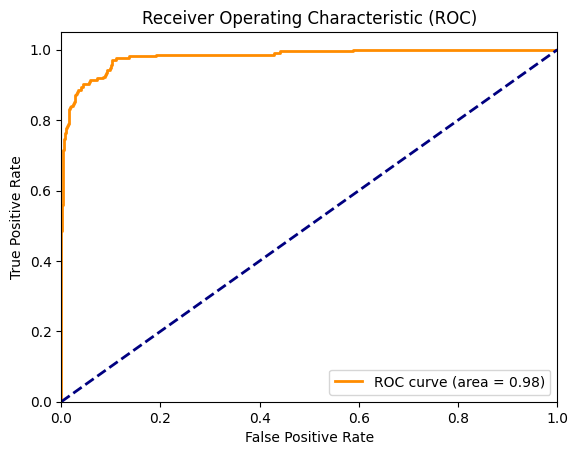

In [ ]:
fpr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

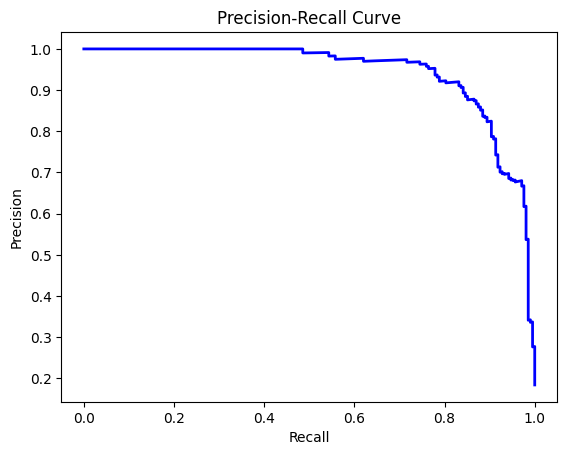

In [ ]:
precision, recall, _ = precision_recall_curve(y, y_pred)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
def predict_acl_tear(task, model_directory, logistic_model):
    planes = ['axial', 'coronal', 'sagittal']
    results = {}
    for plane in planes:
        predictions, labels = extract_predictions(task, plane, train=False)  # Assuming test mode
        results[plane] = predictions
    X = np.zeros((1, 3))
    X[0, 0] = results['axial'][0]
    X[0, 1] = results['coronal'][0]
    X[0, 2] = results['sagittal'][0]
    return prediction[0]
task = 'acl'
model_directory = "/content/drive/MyDrive/Minor Project files/"
logreg = LogisticRegression()
logreg.fit(X, y)  # Load or use your pre-trained model
result = predict_acl_tear(task, model_directory, logreg)
if result == 1:
    print("ACL tear detected (Positive)")
else:
    print("No ACL tear detected (Negative)")


<ipython-input-19-d7b863504d82>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mrnet = torch.load(model_path)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dat

  0%|          | 0/120 [00:00<?, ?it/s]

<ipython-input-19-d7b863504d82>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mrnet = torch.load(model_path)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dat

  0%|          | 0/120 [00:00<?, ?it/s]

<ipython-input-19-d7b863504d82>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mrnet = torch.load(model_path)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dat

  0%|          | 0/120 [00:00<?, ?it/s]

No ACL tear detected (Negative)
